In [357]:
import pulp

In [358]:

soc = [50,40,80,50,90,30]
n = len(soc)
stations = [30,40,50]
speed = 10
charging_rate_station = 10
ex_charging_rate_bess = 5
arrival_time = [7,8,10,13,14,14]
T = 1000
bess_capacity = 100
bess_init = [50,40]

In [359]:
#initiate the model
cs = pulp.LpProblem("station",pulp.LpMinimize)
vehicles=[]
#add variables
soc_vehicle = {}
arrival_time_vehicle = {}
for i in range(n):
    vehicles.append(f"V{i}")
    soc_vehicle[f"V{i}"] = soc[i]
    arrival_time_vehicle[f"V{i}"] = arrival_time[i]
M = 100000
print(vehicles)
#arrival time at stations
a1 = pulp.LpVariable.dict("Arrival Time 1",[vehicle for vehicle in vehicles],lowBound=0,upBound=T,cat=pulp.LpInteger)
a2 = pulp.LpVariable.dict("Arrival Time 2",[vehicle for vehicle in vehicles],lowBound=0,upBound=T,cat=pulp.LpInteger)
# servicing time at stations
s1 = pulp.LpVariable.dict("Service Time 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
s2 = pulp.LpVariable.dict("Service Time 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
#initial charging time at sations
u1 = pulp.LpVariable.dict("initial charge time 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
u2 = pulp.LpVariable.dict("initial charge time 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
#final charge time at stations
d1 = pulp.LpVariable.dict("final charge time 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
d2 = pulp.LpVariable.dict("final charge time 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
# sigma- temporal ordering of vehicles
o1 = pulp.LpVariable.dict("sigma 1",[vehicle1+vehicle2 for vehicle1 in vehicles for vehicle2 in vehicles if vehicle1 != vehicle2],lowBound=0,cat=pulp.LpBinary)
o2 = pulp.LpVariable.dict("sigma 2",[vehicle1+vehicle2 for vehicle1 in vehicles for vehicle2 in vehicles if vehicle1 != vehicle2],lowBound=0,cat=pulp.LpBinary)
# to see if vehicle is gonna use the respective station
sb1 = pulp.LpVariable.dict("Service Time 1 binary",[vehicle for vehicle in vehicles],cat=pulp.LpBinary)
sb2 = pulp.LpVariable.dict("Service Time 2 binary",[vehicle for vehicle in vehicles],cat=pulp.LpBinary)
#bess servicing times at stations
b1 = pulp.LpVariable.dict("BESS service Time 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
b2 = pulp.LpVariable.dict("BESS service Time 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
# charge in bess available for vehicles
bc1 = pulp.LpVariable.dict("BESS charge 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
bc2 = pulp.LpVariable.dict("BESS charge 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpInteger)
# if bess reached max charge or not
charge1 = pulp.LpVariable.dict("reached max charge 1",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpBinary)
charge2 = pulp.LpVariable.dict("reached max charge 2",[vehicle for vehicle in vehicles],lowBound=0,cat=pulp.LpBinary)
#amount to charge
bac1 = pulp.LpVariable.dict("BESS charge for vehicle 1",[vehicle for vehicle in vehicles],cat=pulp.LpInteger)
bac2 = pulp.LpVariable.dict("BESS charge for vehicle 2",[vehicle for vehicle in vehicles],cat=pulp.LpInteger)





['V0', 'V1', 'V2', 'V3', 'V4', 'V5']


In [360]:
#objective function
cs += pulp.lpSum([d1[vehicle]-a1[vehicle] + d2[vehicle]-a2[vehicle]] for vehicle in vehicles)

In [361]:
#constraints
for vehicle in vehicles:
    #departure = service + charge start
    cs += d1[vehicle] == s1[vehicle]+u1[vehicle]
    cs += d2[vehicle] == s2[vehicle]+u2[vehicle]
    
    # charge start > arival time
    cs += u1[vehicle]>=a1[vehicle]
    cs += u2[vehicle]>=a2[vehicle]
    cs += u2[vehicle]<=T-s2[vehicle]
    
    # arrival times of each station
    cs += a1[vehicle] == arrival_time_vehicle[vehicle]+(stations[0]/speed)
    cs += a2[vehicle] == (stations[1]/speed) + d1[vehicle]
    
    # ensuring soc capabilities
    cs += charging_rate_station*s1[vehicle]+ex_charging_rate_bess*b1[vehicle] + soc_vehicle[vehicle]>=stations[0]+stations[1]
    cs += charging_rate_station*s1[vehicle]+ex_charging_rate_bess*b1[vehicle] + soc_vehicle[vehicle]<=100
    cs += charging_rate_station*(s2[vehicle]+s1[vehicle])+ex_charging_rate_bess*(b2[vehicle]+b1[vehicle])+soc_vehicle[vehicle]>=stations[0]+stations[1]+stations[2]
    cs += charging_rate_station*(s2[vehicle]+s1[vehicle])+ex_charging_rate_bess*(b2[vehicle]+b1[vehicle])+soc_vehicle[vehicle]-stations[0]-stations[1]<=100
    
    #to see if a vehicle wants to cross the station or charge there
    cs += M*sb1[vehicle] >= s1[vehicle]
    cs += M*sb1[vehicle] >=s1[vehicle]
    cs += sb1[vehicle] <= s1[vehicle]
    cs += M*sb2[vehicle] >=s2[vehicle]
    cs += sb2[vehicle] <= s2[vehicle]
    # bess time should be less than total charging time at 
    cs += b1[vehicle]<=s1[vehicle]
    cs += b2[vehicle]<=s2[vehicle]
    cs += b1[vehicle]*ex_charging_rate_bess<=bc1[vehicle]
    cs += b2[vehicle]*ex_charging_rate_bess<=bc2[vehicle]
    #checking if the amount we charge is greater than 100 or not
    cs += M*charge1[vehicle]>=bess_init[0]+bac1[vehicle]-bess_capacity
    cs += M*(1-charge1[vehicle]) >= -(bess_init[0]+bac1[vehicle]-bess_capacity)
    cs += M*charge2[vehicle]>=bess_init[1]+bac2[vehicle] - bess_capacity
    cs += M*(1-charge2[vehicle]) >= -(bess_init[1]+bac2[vehicle] - bess_capacity)
    # implementing max of bess capaicty
    cs += bc1[vehicle]>= bess_capacity - M*(1-charge1[vehicle])
    cs += bc1[vehicle]>= bess_init[0] + bac1[vehicle] - M*(charge1[vehicle])
    cs += bc1[vehicle]<= bess_capacity + M*(1-charge1[vehicle])
    cs += bc1[vehicle]<= bess_init[0] + bac1[vehicle] + M*(charge1[vehicle])  
     
    cs += bc2[vehicle]>= bess_capacity - M*(1-charge2[vehicle])
    cs += bc2[vehicle]>= bess_init[1] + bac2[vehicle] - M*(charge2[vehicle])
    cs += bc2[vehicle]<= bess_capacity + M*(1-charge2[vehicle])
    cs += bc2[vehicle]<= bess_init[1] + bac2[vehicle] + M*(charge2[vehicle])

# for bess implementations
for i in range(len(vehicles)):
    cs += bac1[vehicles[i]] ==  (u1[vehicles[i]]-u1[vehicles[0]] - 2*pulp.lpSum([b1[vehicles[j]]] for j in range(i-1,-1,-1)))*ex_charging_rate_bess
    cs += bac2[vehicles[i]] == (u2[vehicles[i]]-u2[vehicles[0]] - 2*pulp.lpSum([b2[vehicles[j]]] for j in range(i-1,-1,-1)))*ex_charging_rate_bess
# for waiting time implementation 
for vehicle1 in vehicles:
    
    for vehicle2 in vehicles:
        if vehicle1!=vehicle2:
            
            #making sure o1[vehicle1+vehicle2] = 1 when vehicle1 in front of vehicle2
            cs += M*o1[vehicle1+vehicle2] >= a1[vehicle2]-a1[vehicle1]
            cs += M*(1-o1[vehicle1+vehicle2])>= a1[vehicle1]-a1[vehicle2]
            cs += M*o2[vehicle1+vehicle2] >= a2[vehicle2]-a2[vehicle1]
            cs += M*(1-o2[vehicle1+vehicle2]) >= a2[vehicle1]-a2[vehicle2]
            
            #implementing wait time
            cs += u1[vehicle2]-u1[vehicle1]-s1[vehicle1]>=(o1[vehicle1+vehicle2]-1)*T-M*(1-sb1[vehicle2])
            cs += u2[vehicle2]-u2[vehicle1]-s2[vehicle1]>=(o2[vehicle1+vehicle2]-1)*T-M*(1-sb2[vehicle2])
            
            #making sure only one vehicle is front of another
            cs += o1[vehicle1+vehicle2] + o1[vehicle2+vehicle1] >= 1
            cs += o2[vehicle1+vehicle2] + o2[vehicle2+vehicle1] >= 1




In [362]:
cs

station:
MINIMIZE
-1*Arrival_Time_1_V0 + -1*Arrival_Time_1_V1 + -1*Arrival_Time_1_V2 + -1*Arrival_Time_1_V3 + -1*Arrival_Time_1_V4 + -1*Arrival_Time_1_V5 + -1*Arrival_Time_2_V0 + -1*Arrival_Time_2_V1 + -1*Arrival_Time_2_V2 + -1*Arrival_Time_2_V3 + -1*Arrival_Time_2_V4 + -1*Arrival_Time_2_V5 + 1*final_charge_time_1_V0 + 1*final_charge_time_1_V1 + 1*final_charge_time_1_V2 + 1*final_charge_time_1_V3 + 1*final_charge_time_1_V4 + 1*final_charge_time_1_V5 + 1*final_charge_time_2_V0 + 1*final_charge_time_2_V1 + 1*final_charge_time_2_V2 + 1*final_charge_time_2_V3 + 1*final_charge_time_2_V4 + 1*final_charge_time_2_V5 + 0
SUBJECT TO
_C1: - Service_Time_1_V0 + final_charge_time_1_V0 - initial_charge_time_1_V0
 = 0

_C2: - Service_Time_2_V0 + final_charge_time_2_V0 - initial_charge_time_2_V0
 = 0

_C3: - Arrival_Time_1_V0 + initial_charge_time_1_V0 >= 0

_C4: - Arrival_Time_2_V0 + initial_charge_time_2_V0 >= 0

_C5: Service_Time_2_V0 + initial_charge_time_2_V0 <= 1000

_C6: Arrival_Time_1_V0 = 10


In [363]:
cs.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/sushi/Desktop/internship/Routing/.venv/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/2f0b9cc96aa64d3783df9ad5e9d45929-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/2f0b9cc96aa64d3783df9ad5e9d45929-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 449 COLUMNS
At line 2092 RHS
At line 2537 BOUNDS
At line 2706 ENDATA
Problem MODEL has 444 rows, 168 columns and 1280 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 25.3333 - 0.00 seconds
Cgl0003I 9 fixed, 80 tightened bounds, 65 strengthened rows, 0 substitutions
Cgl0003I 1 fixed, 30 tightened bounds, 39 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 18 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 16 strengthened rows, 0 substitutions
Cgl0004I pr

1

In [364]:
pulp.LpStatus[cs.status]

'Optimal'

In [367]:
for vehicle in vehicles:
    print(f"{vehicle} waits at s1 for {u1[vehicle].varValue-a1[vehicle].varValue}, s2: for {u2[vehicle].varValue-a2[vehicle].varValue}")
    print(f"{vehicle} charges at s1 for {b1[vehicle].varValue} using the bess and station, and for {s1[vehicle].varValue-b1[vehicle].varValue} only using station")
    print(f"{vehicle} charges at s2 for {b2[vehicle].varValue} using the bess and station, and for {s2[vehicle].varValue-b2[vehicle].varValue} only using station")
    print(f"{vehicle} reaches s1 , s2 at {a1[vehicle].varValue, a2[vehicle].varValue}")
    print(f"bess energy level for {vehicle} is {bc1[vehicle].varValue},{bc2[vehicle].varValue}")
    print(f"{vehicle} charges s1 , s2 at {u1[vehicle].varValue, u2[vehicle].varValue}")
    print(f"{vehicle} charge at s1 , s2 at {charge1[vehicle].varValue, charge2[vehicle].varValue}")

    print()

V0 waits at s1 for 0.0, s2: for 0.0
V0 charges at s1 for 2.0 using the bess and station, and for 1.0 only using station
V0 charges at s2 for 2.0 using the bess and station, and for 0.0 only using station
V0 reaches s1 , s2 at (10.0, 17.0)
bess energy level for V0 is 50.0,40.0
V0 charges s1 , s2 at (10.0, 17.0)
V0 charge at s1 , s2 at (0.0, 0.0)

V1 waits at s1 for 2.0, s2: for 1.0
V1 charges at s1 for 3.0 using the bess and station, and for 1.0 only using station
V1 charges at s2 for 1.0 using the bess and station, and for 1.0 only using station
V1 reaches s1 , s2 at (11.0, 21.0)
bess energy level for V1 is 45.0,45.0
V1 charges s1 , s2 at (13.0, 22.0)
V1 charge at s1 , s2 at (0.0, 0.0)

V2 waits at s1 for 2.0, s2: for 0.0
V2 charges at s1 for 0.0 using the bess and station, and for 0.0 only using station
V2 charges at s2 for 2.0 using the bess and station, and for 1.0 only using station
V2 reaches s1 , s2 at (13.0, 19.0)
bess energy level for V2 is 25.0,20.0
V2 charges s1 , s2 at (15.0

In [368]:
print(pulp.value(cs.objective))

41.0


Code to graph outputs

In [369]:
import seaborn

In [370]:
state = {}
for vehicle in vehicles:
    state[vehicle] = []
max_len = 0
for vehicle in vehicles:
    for i in range(int(stations[0]/speed)):
        state[vehicle].append("driving")
    for j in range(int(u1[vehicle].varValue-a1[vehicle].varValue)):
        state[vehicle].append("waiting")
    for k in range(int(s1[vehicle].varValue)):
        state[vehicle].append("charging")
    for l in range(int(stations[1]/speed)):
        state[vehicle].append("driving")
    for v in range(int(u2[vehicle].varValue-a2[vehicle].varValue)):
        state[vehicle].append("waiting")
    for k in range(int(s2[vehicle].varValue)):
        state[vehicle].append("charging")
    for i in range(int(stations[2]/speed)):
        state[vehicle].append("driving")
    if len(state[vehicle])>max_len:
        max_len = len(state[vehicle])
for vehicle in vehicles:
    if len(state[vehicle]) < max_len:
        for i in range(max_len-len(state[vehicle])):
            state[vehicle].append("reached")
# state is first graph variable     max_ len is max time       
            
soc_trucks = {}
max_len_soc = 0
for vehicle in vehicles:
    soc_trucks[vehicle] = [soc_vehicle[vehicle]]
for vehicle in vehicles:
    for i in range(int(stations[0]/speed)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]-speed)
    for j in range(int(u1[vehicle].varValue-a1[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1])
    for k in range(int(b1[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+ex_charging_rate_bess+charging_rate_station)
    for i in range(int(s1[vehicle].varValue-b1[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+charging_rate_station)
    for l in range(int(stations[1]/speed)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]-speed)
    for v in range(int(u2[vehicle].varValue-a2[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1])
    for k in range(int(b2[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+ex_charging_rate_bess+charging_rate_station)
    for i in range(int(s2[vehicle].varValue-b2[vehicle].varValue)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]+charging_rate_station)
    for i in range(int(stations[2]/speed)):
        soc_trucks[vehicle].append(soc_trucks[vehicle][-1]-speed)
    if len(soc_trucks[vehicle])>max_len_soc:
        max_len_soc = len(soc_trucks[vehicle])
for vehicle in vehicles:
    if len(soc_trucks[vehicle]) < max_len_soc:
        for i in range(max_len_soc-len(soc_trucks[vehicle])):
            soc_trucks[vehicle].append(soc_trucks[vehicle][-1])
print(soc_trucks)
print(max_len_soc)

{'V0': [50, 40, 30, 20, 35, 50, 60, 50, 40, 30, 20, 35, 50, 40, 30, 20, 10, 0, 0, 0, 0, 0], 'V1': [40, 30, 20, 10, 10, 10, 25, 40, 55, 65, 55, 45, 35, 25, 25, 40, 50, 40, 30, 20, 10, 0], 'V2': [80, 70, 60, 50, 50, 50, 40, 30, 20, 10, 25, 40, 50, 40, 30, 20, 10, 0, 0, 0, 0, 0], 'V3': [50, 40, 30, 20, 20, 35, 50, 65, 55, 45, 35, 25, 25, 25, 40, 50, 40, 30, 20, 10, 0, 0], 'V4': [90, 80, 70, 60, 50, 40, 30, 20, 20, 20, 20, 35, 50, 40, 30, 20, 10, 0, 0, 0, 0, 0], 'V5': [30, 20, 10, 0, 0, 0, 0, 15, 30, 45, 60, 50, 40, 30, 20, 35, 50, 40, 30, 20, 10, 0]}
22


In [371]:
soc_bess = [[bess_init[0]],[bess_init[1]]]
bess_state = [[],[]]
for i  in range(len(vehicles)):
    if i == 0:
        for j in range(int(u1[vehicles[i]].varValue)):
            bess_state[0].append("idle")
            soc_bess[0].append(soc_bess[0][-1])
        for j in range(int(b1[vehicles[i]].varValue)):
            bess_state[0].append("discharging")
            soc_bess[0].append(soc_bess[0][-1]-ex_charging_rate_bess)
        for j in range(int(s1[vehicles[i]].varValue-b1[vehicles[i]].varValue)):
            if soc_bess[0][-1] == bess_capacity:
                bess_state[0].append("idle")
                soc_bess[0].append(soc_bess[0][-1])
            else:
                bess_state[0].append("charging")
                soc_bess[0].append(soc_bess[0][-1]+ex_charging_rate_bess)
    else:
        for j in range(int(u1[vehicles[i]].varValue-u1[vehicles[i-1]].varValue-b1[vehicles[i-1]].varValue)):
            if soc_bess[0][-1] == bess_capacity:
                bess_state[0].append("idle")
                soc_bess[0].append(soc_bess[0][-1])
            else:
                bess_state[0].append("charging")
                soc_bess[0].append(soc_bess[0][-1]+ex_charging_rate_bess)
        for j in range(int(b1[vehicles[i]].varValue)):
            bess_state[0].append("discharging")
            soc_bess[0].append(soc_bess[0][-1]-ex_charging_rate_bess)
        for j in range(int(s1[vehicles[i]].varValue-b1[vehicles[i]].varValue)):
            if soc_bess[0][-1] == bess_capacity:
                bess_state[0].append("idle")
                soc_bess[0].append(soc_bess[0][-1])
            else:
                bess_state[0].append("charging")
                soc_bess[0].append(soc_bess[0][-1]+ex_charging_rate_bess)

for i  in range(len(vehicles)):
    if i == 0:
        for j in range(int(u2[vehicles[i]].varValue)):
            bess_state[1].append("idle")
            soc_bess[1].append(soc_bess[1][-1])
        for j in range(int(b2[vehicles[i]].varValue)):
            bess_state[1].append("discharging")
            soc_bess[1].append(soc_bess[1][-1]-ex_charging_rate_bess)
        for j in range(int(s2[vehicles[i]].varValue-b2[vehicles[i]].varValue)):
            if soc_bess[1][-1] == bess_capacity:
                bess_state[1].append("idle")
                soc_bess[1].append(soc_bess[1][-1])
            else:
                bess_state[1].append("charging")
                soc_bess[1].append(soc_bess[1][-1]+ex_charging_rate_bess)
    else:
        for j in range(int(u2[vehicles[i]].varValue-u2[vehicles[i-1]].varValue-b2[vehicles[i-1]].varValue)):
            if soc_bess[1][-1] == bess_capacity:
                bess_state[1].append("idle")
                soc_bess[1].append(soc_bess[1][-1])
            else:
                bess_state[1].append("charging")
                soc_bess[1].append(soc_bess[1][-1]+ex_charging_rate_bess)
        for j in range(int(b2[vehicles[i]].varValue)):
            bess_state[1].append("discharging")
            soc_bess[1].append(soc_bess[1][-1]-ex_charging_rate_bess)
        for j in range(int(s2[vehicles[i]].varValue-b2[vehicles[i]].varValue)):
            if soc_bess[1][-1] == bess_capacity:
                bess_state[1].append("idle")
                soc_bess[1].append(soc_bess[1][-1])
            else:
                bess_state[1].append("charging")
                soc_bess[1].append(soc_bess[1][-1]+ex_charging_rate_bess)


print(bess_state)
print(soc_bess)

        

for vehicle in vehicles:
    if len(state[vehicle]) < max_len:
        for i in range(max_len-len(state[vehicle])):
            state[vehicle].append("reached")
max_len_bess = max(len(soc_bess[0]),len(soc_bess[1]))
for i in range(len(soc_bess)):
    for j in range(max_len_bess-len(soc_bess[i])):
        bess_state[i].append("idle")
        soc_bess[i].append(soc_bess[i][-1])
print(len(bess_state[0]),len(bess_state[1]))
soc_bess[0].pop(0)
soc_bess[1].pop(0)


[['idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'discharging', 'discharging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'discharging'], ['idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'charging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'charging', 'charging', 'charging', 'discharging', 'charging', 'discharging', 'discharging', 'charging', 'charging', 'discharging', 'discharging']]
[[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 45, 40, 45, 50, 45, 40, 35, 40, 45, 50, 45, 40, 35, 40, 45, 50, 45, 40, 35, 30], [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4

40

In [372]:
wait_time = {}
for vehicle in vehicles:
    wait_time[vehicle] = [u1[vehicle].varValue-a1[vehicle].varValue,u2[vehicle].varValue-a2[vehicle].varValue]
print(wait_time)


{'V0': [0.0, 0.0], 'V1': [2.0, 1.0], 'V2': [2.0, 0.0], 'V3': [1.0, 2.0], 'V4': [0.0, 3.0], 'V5': [3.0, 0.0]}


In [373]:
print(bess_state)
print(soc_bess)
print(wait_time)
print(soc_trucks)
print(state)

[['idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'discharging', 'discharging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'discharging', 'discharging', 'discharging', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle'], ['idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'idle', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'discharging', 'charging', 'discharging', 'discharging', 'charging', 'charging', 'charging', 'charging', 'charging', 'charging', 'discharging', 'charging', 'discharging', 'discharging', 'charging', 'charging', 'discharging', 'discharging']]
[[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 45, 40, 45, 50, 45, 40, 35, 40, 45, 50, 45, 40, 35, 40, 45, 50, 45, 40, 35,

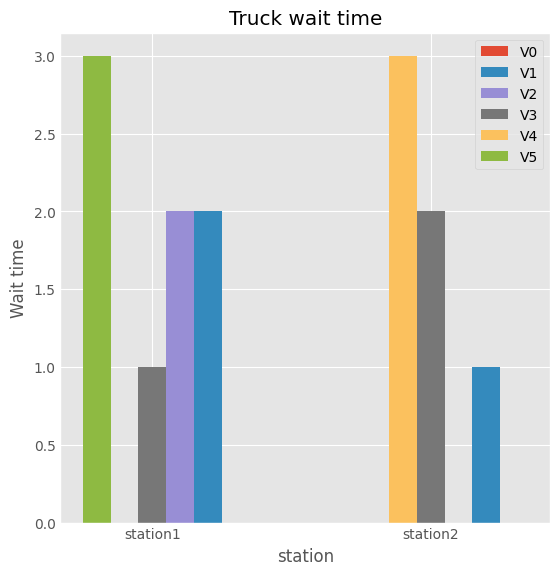

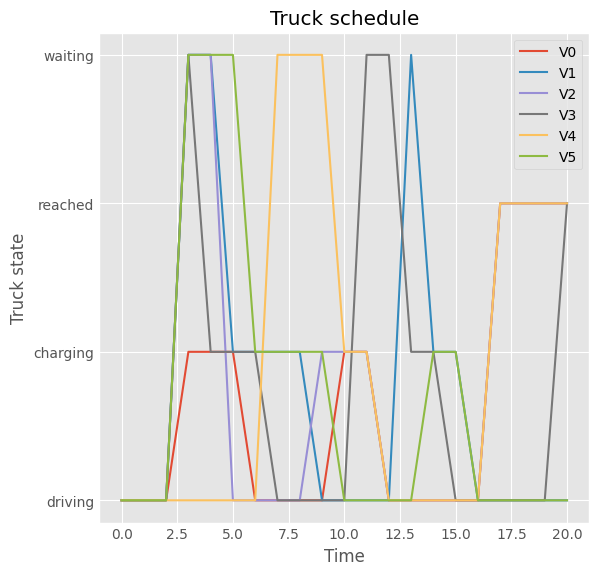

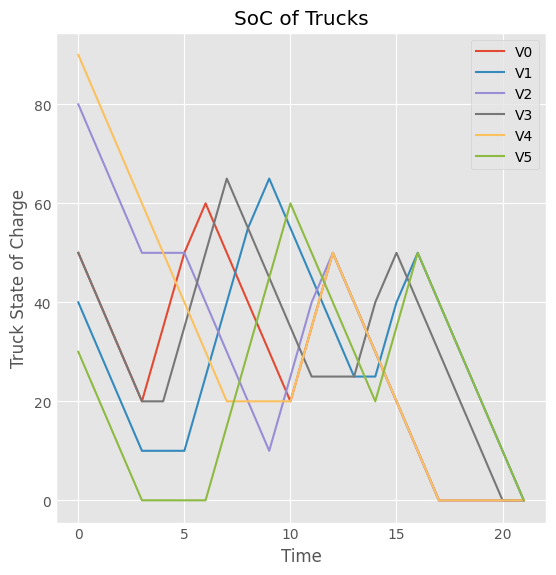

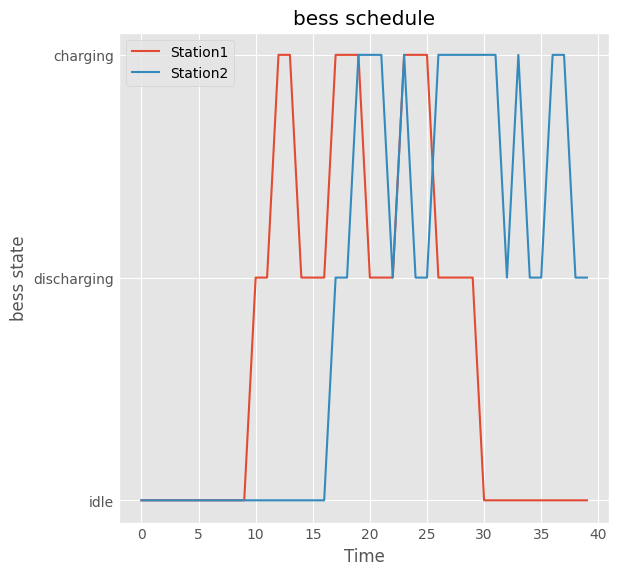

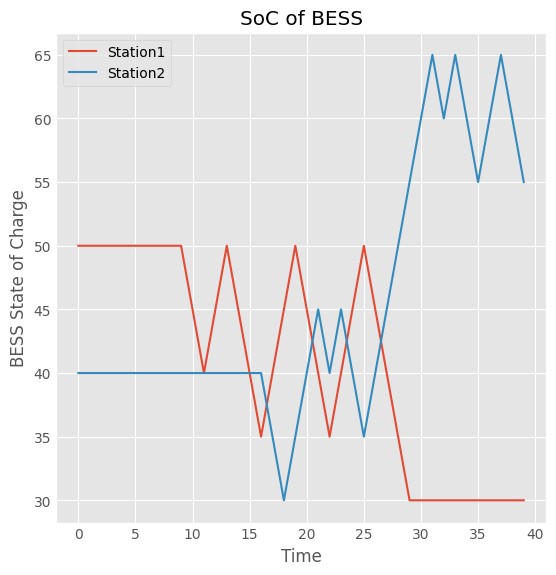

 schedule of trucks | depot dept | station 1 arrival | charge start | charge end | station 1 dept | station 2 arrival | charge start | charge end | station 2 dept | arrival to destination |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
         V0         |     7      |        10         |      10      |     13     |       13       |        17         |      17      |     19     |       19       |           24           |
         V1         |     8      |        11         |      13      |     17     |       17       |        21         |      22      |     24     |       24       |           29           |
         V2         |     10     |        13         |      15      |     15     |       15       |        19         |      19      |     22     |       22       |           27           |
         V3         |     13     |        16      

In [374]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = [[] for i in range(len(vehicles))]
for i in range(len(vehicles)):
    plot[i]=wait_time[vehicles[i]]

# Sample data
data1 = plot[0]
data2 = plot[1]



import numpy as np  
import matplotlib.pyplot as plt  
X = ["station1","station2"]
plt.figure(figsize=(5,5))  
X_axis = np.arange(len(X)) 
for i in range(len(vehicles)):
    plt.bar(X_axis - 0.1*(i-(len(vehicles)//2)), plot[i], 0.1, label = vehicles[i])  
  
plt.xticks(X_axis, X) 
plt.xlabel("station") 
plt.ylabel("Wait time") 
plt.title("Truck wait time") 
plt.legend() 
plt.show() 


plt.figure(figsize=(5,5))
plt.style.use('ggplot')
# create data 
x = list(range(len(state[vehicles[0]]))) 
# plot lines 
for vehicle in vehicles:
    plt.plot(x, state[vehicle], label = vehicle) 
plt.xlabel("Time") 
plt.ylabel("Truck state") 
plt.title("Truck schedule") 
plt.legend() 
plt.show() 

plt.figure(figsize=(5,5))

x = list(range(max_len_soc)) 
# plot lines 
for vehicle in vehicles:
    plt.plot(x, soc_trucks[vehicle], label = vehicle)
plt.xlabel("Time") 
plt.ylabel("Truck State of Charge") 
plt.title("SoC of Trucks")  
plt.legend() 
plt.show()

plt.figure(figsize=(5,5))
x = list(range(len(bess_state[0]))) 
# plot lines 
for i in range(2):
    plt.plot(x, bess_state[i], label = f"Station{i+1}") 
plt.xlabel("Time") 
plt.ylabel("bess state") 
plt.title("bess schedule") 
plt.legend() 
plt.show() 

plt.figure(figsize=(5,5))

x = list(range(len(soc_bess[0])))
# plot lines 
for i in range(2):
    plt.plot(x, soc_bess[i], label = f"Station{i+1}") 
plt.xlabel("Time") 
plt.ylabel("BESS State of Charge") 
plt.title("SoC of BESS")  
plt.legend() 
plt.show()

print(" schedule of trucks | depot dept | station 1 arrival | charge start | charge end | station 1 dept | station 2 arrival | charge start | charge end | station 2 dept | arrival to destination |")
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
for vehicle in vehicles:
    print_str = ""
    for i in range((20-len(vehicle))//2):
        print_str +=" "
    for i in range((len(vehicle))):
        print_str += vehicle[i]
    if (20-len(vehicle))%2==0:
        for i in range((20-len(vehicle))//2):
            print_str +=" "
    else:
        for i in range((20-len(vehicle))//2+1):
            print_str +=" "
    print_str += "|"
    
    l = list(str(arrival_time_vehicle[vehicle]))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
        
    print_str += "|"
    #print(print_str)
    l = list(str(int(a1[vehicle].varValue)))
    for i in range((19-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (19-len(l))%2==0:
        for i in range((19-len(l))//2):
            print_str +=" "
    else:
        for i in range((19-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue)))
    for i in range((14-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (14-len(l))%2==0:
        for i in range((14-len(l))//2):
            print_str +=" "
    else:
        for i in range((14-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue+s1[vehicle].varValue)))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u1[vehicle].varValue+s1[vehicle].varValue)))
    for i in range((16-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (16-len(l))%2==0:
        for i in range((16-len(l))//2):
            print_str +=" "
    else:
        for i in range((16-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(a2[vehicle].varValue)))
    for i in range((19-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (19-len(l))%2==0:
        for i in range((19-len(l))//2):
            print_str +=" "
    else:
        for i in range((19-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue)))
    for i in range((14-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (14-len(l))%2==0:
        for i in range((14-len(l))//2):
            print_str +=" "
    else:
        for i in range((14-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue)))
    for i in range((12-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (12-len(l))%2==0:
        for i in range((12-len(l))//2):
            print_str +=" "
    else:
        for i in range((12-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue)))
    for i in range((16-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (16-len(l))%2==0:
        for i in range((16-len(l))//2):
            print_str +=" "
    else:
        for i in range((16-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    l = list(str(int(u2[vehicle].varValue+s2[vehicle].varValue + stations[-1]/speed)))
    for i in range((24-len(l))//2):
        print_str +=" "
    for i in range(len(l)):
        print_str += l[i]
    if (24-len(l))%2==0:
        for i in range((24-len(l))//2):
            print_str +=" "
    else:
        for i in range((24-len(l))//2+1):
            print_str +=" "
    print_str += "|"
    print(print_str)
    

        
    



